# Guided Iteration Example

This is an example of the type of iterative loop one can write for selecting high-level features according to their average decision ordering value. In the class `GuidedIterator`, I have written a method for looping through each feature in a dataset of EFPs (`data/EFP.parquet`) and selecting the best performing example by ADO. This feature is then included as a new feature in model training and the ADO comparison is made again with the remaining EFPs. 

In this example, an XGBoost model (XGBClassifier) is the model trained in the `train_nn` function. However, this can be replaced with any binary classifier. 

The results of each iteration of the loop are saved in the `results` directory. There is an overall results file (`results.csv`) which includes the selected EFP and the AUC and ADO value for the HL+EFP network trained. Additionally, there is a directory for each iteration (e.g. `iteration_0`, `iteration_1`, etc) with the raw predictions, difference ordering values and sorted ado scores for each EFP tested. 

# Example Run

A small set of sample data is given in the directory `data`. This specific iterator requires 4 sets of data. These are
- **HL**: A dataframe of all HL features
- **EFP**: A dataframe of all EFPs we want to include in our search
- **ll_predictions**: An array of all predictions from the LL model we are using as our guide
- **targets**: The truth labels.

Note that for all 4 datasets, each row/entry must correpond to the same event. If we plot the sample data, we get the following:

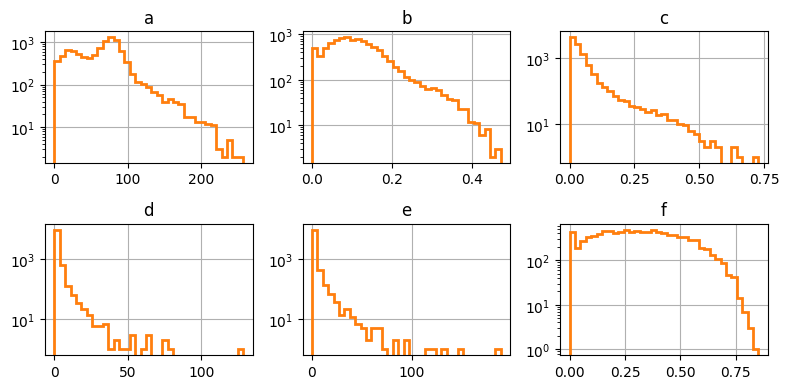

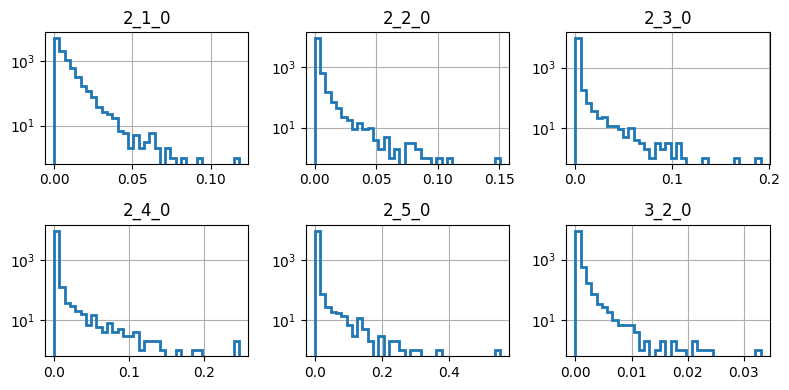

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
home = pathlib.Path.cwd()
data_path = home / "data"

hl = pd.read_parquet(data_path / "HL.parquet")
hl.hist(bins=35, layout=(-1,3), figsize=(8,4), log=True, histtype="step", linewidth=2, color="tab:orange")
plt.tight_layout()
plt.show()

# I'm only plotting a few of the first EFPs
efp = pd.read_parquet(data_path / "EFP.parquet")
efp.iloc[:, [1,2,3,4,5,6]].hist(bins=35, layout=(-1,3), figsize=(8,4), log=True, histtype="step", linewidth=2, color="tab:blue")
plt.tight_layout()
plt.show()

# Running Guided Iteration

We can now run the GuidedIterator method with this dataset. The method only requires 4 inputs. 

- **run_name**: This is just a human-readable name where all of the results will be stored
- **benchmark**: The AUC value for the LL network we are trying to match. If the guided process matches/beats this result the iterator stops running.
- **max_iterations**: In case the iterator doesn't manage to match the LL results, this value will stop the process at the number of max_iterations selected.
- **n_pairs**: The number of signal/background pairs you want to use in the ADO calculations. 

In [2]:
from GuidedIterator import GuidedIterator
benchmark = 0.872
GuidedIterator(run_name="demo", benchmark=benchmark, n_pairs=50_000, max_iterations=10).run()

Iteration 1:  10%|█         | 1/10 [00:00<00:04,  1.97it/s]

test-set AUC=0.8564
Iteration 0 -> AUC: 0.8564
Skipping isolate_order for pass 0
Skipping check_efps for pass 0
Maximum dif-order graph selected: 2_1_0
test-set AUC=0.8689
Iteration 1 -> AUC: 0.8689
Skipping isolate_order for pass 1
Checking ADO on diff-order subset of size N = 99
removing previously selected efps:  ['2_1_0']


Iteration 2:  20%|██        | 2/10 [00:01<00:05,  1.37it/s]

Maximum dif-order graph selected: 1_0_0
test-set AUC=0.8645
Iteration 2 -> AUC: 0.8645
Generating (N=50,000) sig/bkg pairs
Checking ADO on diff-order subset of size N = 122
removing previously selected efps:  ['2_1_0', '1_0_0']


Iteration 3:  30%|███       | 3/10 [00:02<00:06,  1.13it/s]

Maximum dif-order graph selected: 6_5_2
test-set AUC=0.872
Iteration 3 -> AUC: 0.872
Generating (N=50,000) sig/bkg pairs
Checking ADO on diff-order subset of size N = 102
removing previously selected efps:  ['2_1_0', '1_0_0', '6_5_2']


Iteration 3:  30%|███       | 3/10 [00:03<00:08,  1.17s/it]

Maximum dif-order graph selected: 3_5_1
Iteration has reached the LL benchmark
Terminating early on iteration: 3


## Plotting Results
Because the final results are summarized in `results.csv` we can read in that file and plot the changes in performance as a function of the iteration

,features,auc,ado
0,HL,0.856431,0.000000
1,2_1_0,0.868938,0.612903
2,1_0_0,0.864508,0.575758
3,6_5_2,0.872007,0.598361


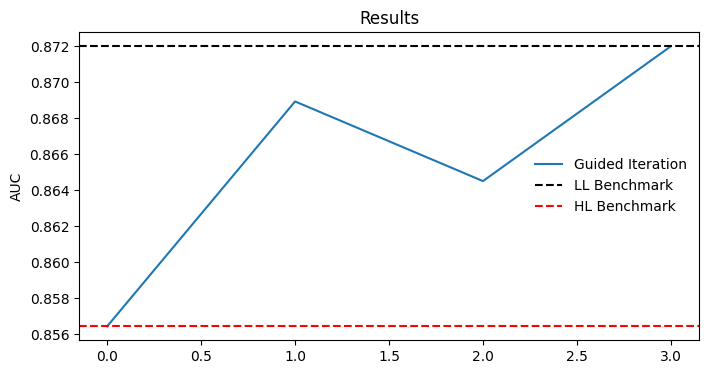

In [6]:
results = pd.read_csv(home / "results" / "demo" / "results.csv", index_col=[0])
display(results)
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(results["auc"], label="Guided Iteration")
ax.axhline(benchmark, linestyle="--", color='k', label="LL Benchmark")
ax.axhline(results["auc"][0], linestyle="--", color='r', label="HL Benchmark")
ax.set_ylabel("AUC")
ax.set_title("Results")
plt.legend(frameon=False)
plt.savefig(home / "results" / "demo" / "results.png")